# Retail Customer Segmentation

### Business Objective:
To improve customer relationship management and marketing strategies by identifying distinct customer segments based on purchasing behavior.

### Business Question:
How can we segment our customer base to better understand their purchasing behaviors and preferences in order to tailor marketing strategies, improve customer retention, and increase overall sales?

### Specific Goals:
1. Identify Key Customer Segments: Use RFM (Recency, Frequency, Monetary) analysis to categorize customers into distinct groups based on their purchasing behavior.
2. Understand Customer Characteristics: Analyze the characteristics of each customer segment to gain insights into their behaviors and preferences.
3. Optimize Marketing Strategies: Develop targeted marketing strategies tailored to the specific needs and behaviors of each customer segment.
4. Enhance Customer Retention: Identify high-value and at-risk customers to implement retention strategies and increase customer loyalty.
5. Improve Sales and Revenue: Leverage customer insights to drive sales growth and enhance the overall profitability of the business.

### Expected Outcomes:
- Clear identification of different customer segments based on RFM analysis.
- Detailed profiles of each customer segment with actionable insights.
- Data-driven marketing strategies that are customized for each segment to maximize engagement and conversion rates.
- Strategies to retain high-value customers and re-engage inactive ones.
- Increased efficiency in marketing spend and improved return on investment (ROI).

#
### Code

### Importing the necessary libraries

In [61]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

### Reading the dataset

In [62]:
retail_df = pd.read_excel('/Users/Tiana/Desktop/online_retail_II.xlsx', sheet_name='Year 2010-2011')
retail_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [63]:
#Viewing the no. of rows and columns in the dataset
retail_df.shape

(541910, 8)

In [64]:
#Check the datatyp of each column and the null values (if any)
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [65]:
#Preliminary statistics of the quatitative columns in the dataframe
retail_df.describe()

,Quantity,Price,Customer ID
count,541910.000000,541910.000000,406830.000000
mean,9.552234,4.611138,15287.684160
std,218.080957,96.759765,1713.603074
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Data Preprocessing

In [66]:
# Drop rows with missing values (if any)
retail_df.dropna(inplace=True)

In [67]:
#Check the shape after dropping the missing values
retail_df.shape

(406830, 8)

In [68]:
#Since rows with quantity = 0 or price = 0 do not affect the analysis, filter out negative or zero quantities
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['Price'] > 0]

In [69]:
# Convert InvoiceDate to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'])
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397885 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      397885 non-null  object        
 1   StockCode    397885 non-null  object        
 2   Description  397885 non-null  object        
 3   Quantity     397885 non-null  int64         
 4   InvoiceDate  397885 non-null  datetime64[ns]
 5   Price        397885 non-null  float64       
 6   Customer ID  397885 non-null  float64       
 7   Country      397885 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [70]:
# Creating a Total_Price column
retail_df['Total_Price'] = retail_df['Quantity'] * retail_df['Price']

#View the dataset
retail_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### RFM Metrics

In [71]:
# Create columns for Recency, Frequency, and Monetary (RFM)
cutoff_date = retail_df['InvoiceDate'].max() + pd.DateOffset(1)
#Creating a new dataframe with the rfm values
rfm = retail_df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (cutoff_date - x.max()).days,
    'Invoice': 'nunique',
    'Total_Price': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

#Checking the rfm dataframe
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


### RFM Segmentation

In [72]:
#Calculate quantiles
quantiles = rfm.quantile(q=[0.25, 0.50, 0.75])
#Convert to dictionary
quantiles = quantiles.to_dict()

In [73]:
#Define r_score function
def r_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

`r_score` function assigns scores to Recency values by comparing each value `x` to the 25th, 50th, and 75th percentiles in the dictionary d for the specified column p. Lower Recency values indicate more recent purchases and are assigned a higher r_score.

In [74]:
#Define fm_score function
def fm_score(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

`fm_score` function assigns scores to Frequency and Monetary values by comparing each value `x` to the percentiles in d for the specified column p.Higher Frequency and Monetary values are assigned a higher score

In [75]:
#Applying Scoring Functions to the dataset
rfm['R'] = rfm['Recency'].apply(r_score, args=('Recency', quantiles))
rfm['F'] = rfm['Frequency'].apply(fm_score, args=('Frequency', quantiles))
rfm['M'] = rfm['Monetary'].apply(fm_score, args=('Monetary', quantiles))

In [76]:
# Combine RFM score and view the dataset
rfm['RFM_Score'] = rfm.R.map(str) + rfm.F.map(str) + rfm.M.map(str)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,12346.0,326,1,77183.60,4,4,1,441
1,12347.0,2,7,4310.00,1,1,1,111
2,12348.0,75,4,1797.24,3,2,1,321
3,12349.0,19,1,1757.55,2,4,1,241
4,12350.0,310,1,334.40,4,4,3,443


### Clustering using Hierarchical Clustering

In [77]:
# Standardize the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

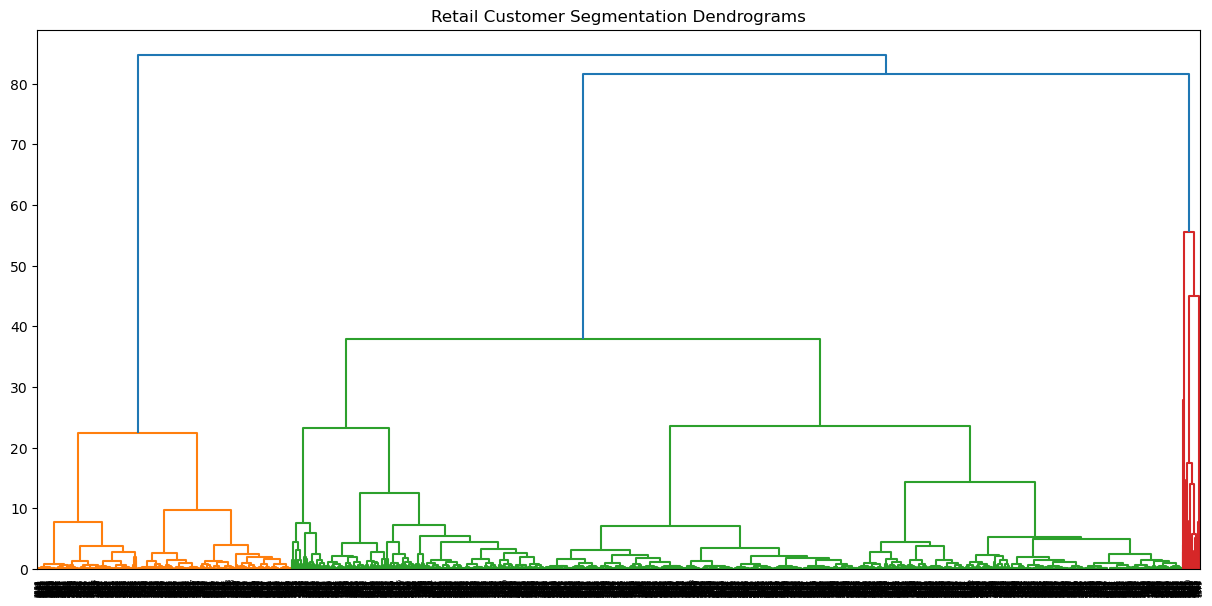

In [78]:
# Create and view the clustering dendrogram
plt.figure(figsize=(15,7))
plt.title("Retail Customer Segmentation Dendrograms")
dend = dendrogram(linkage(rfm_scaled, method='ward'))

Linkage matrix is computed using the Ward variance minimization algorithm, which minimizes the variance within each cluster.

In [79]:
#Perform hierarchial clustering and assign cluster labels to the data points
hc = sch.linkage(rfm_scaled, method='ward')
cluster_labels = fcluster(hc, t=5, criterion='maxclust')

In [80]:
#Adding cluster labels to RFM dataframe
rfm['H_Cluster'] = cluster_labels

#View the dataframe
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score,H_Cluster
0,12346.0,326,1,77183.60,4,4,1,441,4
1,12347.0,2,7,4310.00,1,1,1,111,2
2,12348.0,75,4,1797.24,3,2,1,321,2
3,12349.0,19,1,1757.55,2,4,1,241,2
4,12350.0,310,1,334.40,4,4,3,443,1


### Clustering using K-Means

/Users/Tiana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/Tiana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/Tiana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/Tiana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

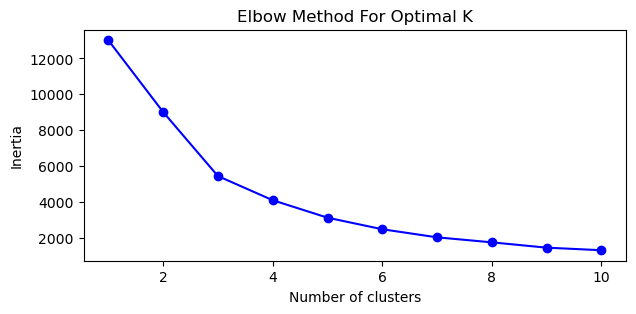

In [96]:
# Elbow Method for Optimal K
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7, 3))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

In [81]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(rfm_scaled)
rfm['K_Cluster'] = kmeans.labels_

# View the dataset
rfm.head()

/Users/Tiana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score,H_Cluster,K_Cluster
0,12346.0,326,1,77183.60,4,4,1,441,4,2
1,12347.0,2,7,4310.00,1,1,1,111,2,0
2,12348.0,75,4,1797.24,3,2,1,321,2,0
3,12349.0,19,1,1757.55,2,4,1,241,2,0
4,12350.0,310,1,334.40,4,4,3,443,1,1


### Visualizing the Clusters

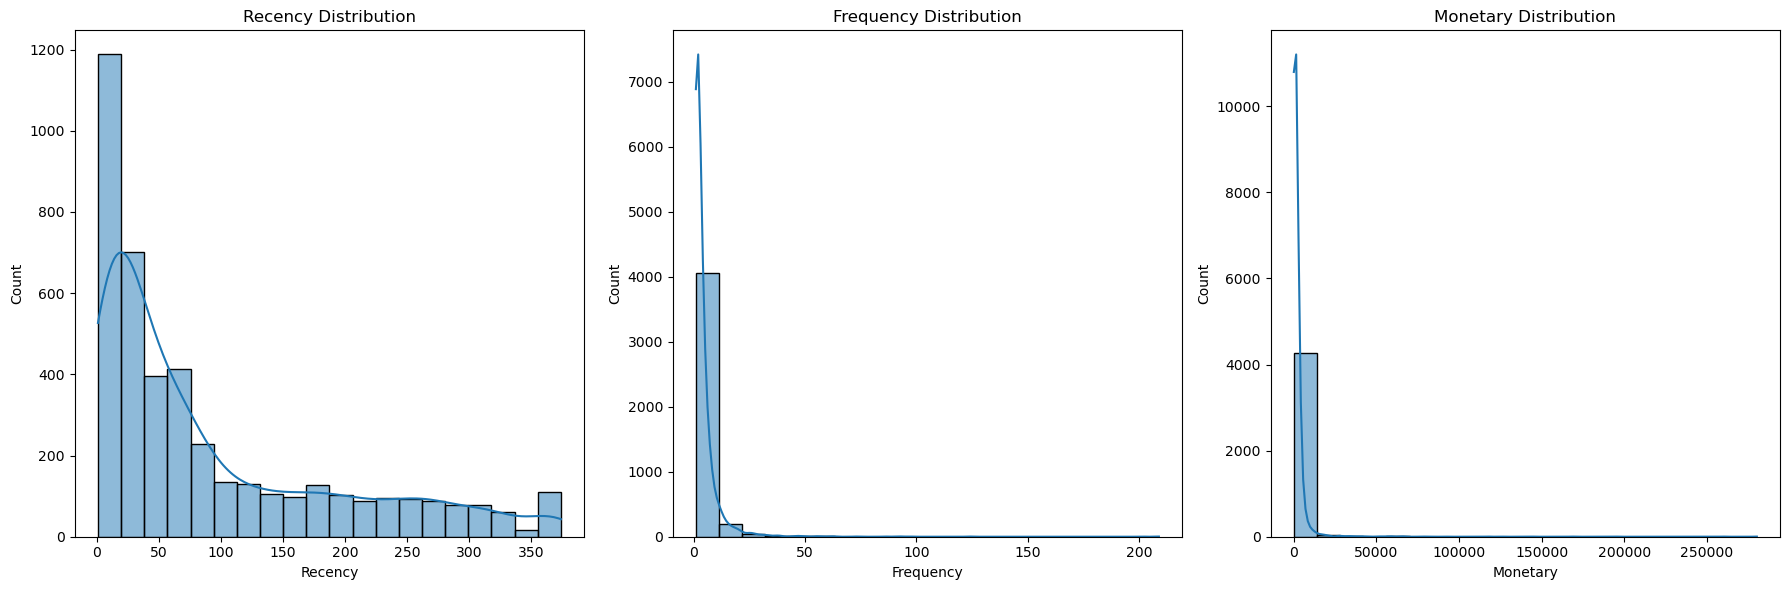

In [89]:
# Distribution of Recency, Frequency, and Monetary
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(rfm['Recency'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Recency Distribution')
sns.histplot(rfm['Frequency'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Frequency Distribution')
sns.histplot(rfm['Monetary'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Monetary Distribution')
plt.tight_layout()
plt.show()

**Recency Distribution Plot**
Shows how recently customers have made purchases. A distribution skewed towards lower values indicates that most customers have made recent purchases which is a positive indicator of customer engagement.

**Frequency Distribution Plot**
Shows how often customers make purchases. A right-skewed plot indicates most customers have made only a few purchases. This goes on to show that while the business attracts many new customers, there is a need to focus on increasing repeat purchases through loyalty programs or targeted marketing to improve customer retention.

**Monetary Distribution Plot**
This plot illustrates the total amount spent by customers. A right-skewed distribution shows that most customers spend relatively little. This indicates a need for strategies to increase the average order value, such as bundling products, offering discounts on bulk purchases, or upselling higher-value items.

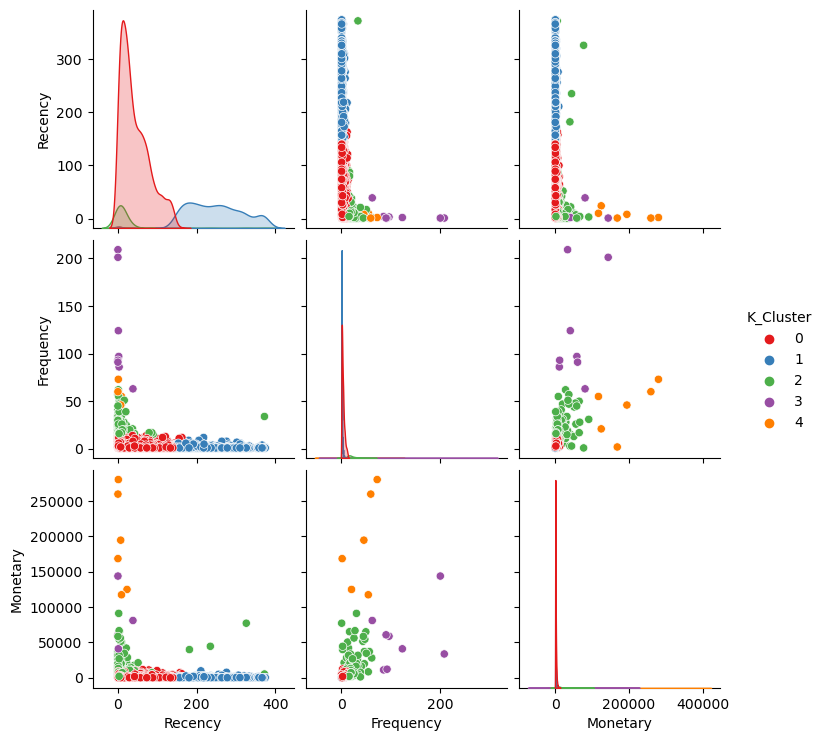

In [91]:
# Pairplot of RFM metrics with K-Means clusters
sns.pairplot(rfm, vars=['Recency', 'Frequency', 'Monetary'], hue='K_Cluster', palette='Set1')
plt.show()

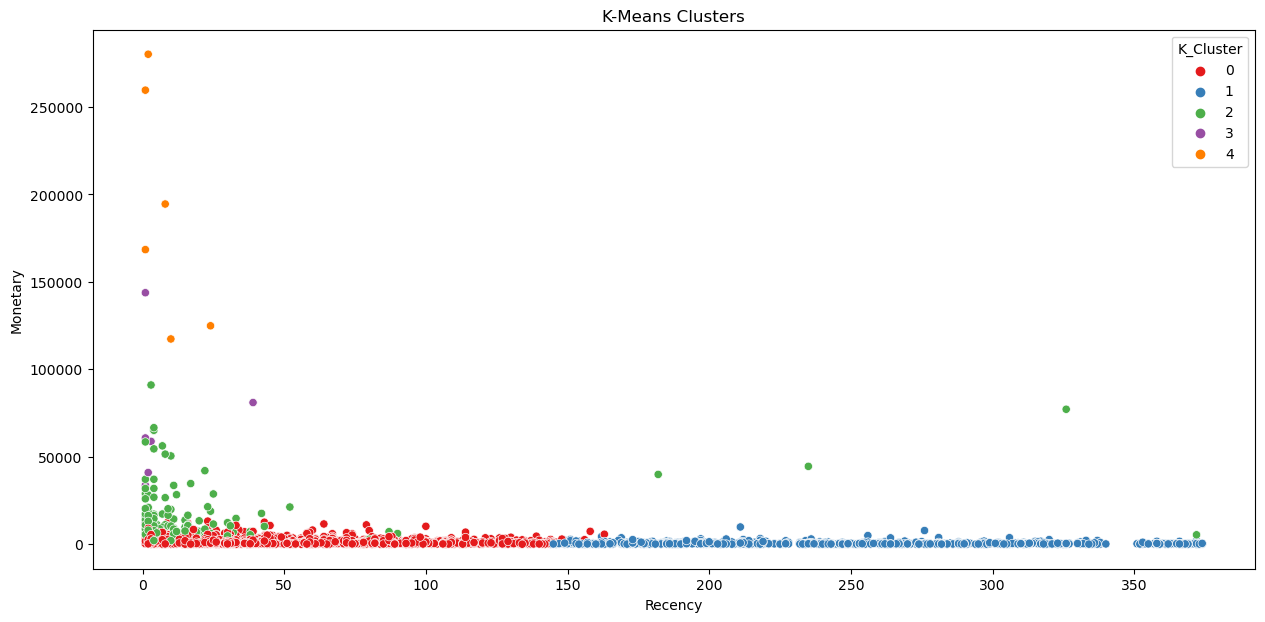

In [82]:
# Plotting the clusters on a scatter plot
plt.figure(figsize=(15, 7))
sns.scatterplot(x='Recency', y='Monetary', hue='K_Cluster', data=rfm, palette='Set1')
plt.title('K-Means Clusters')
plt.show()

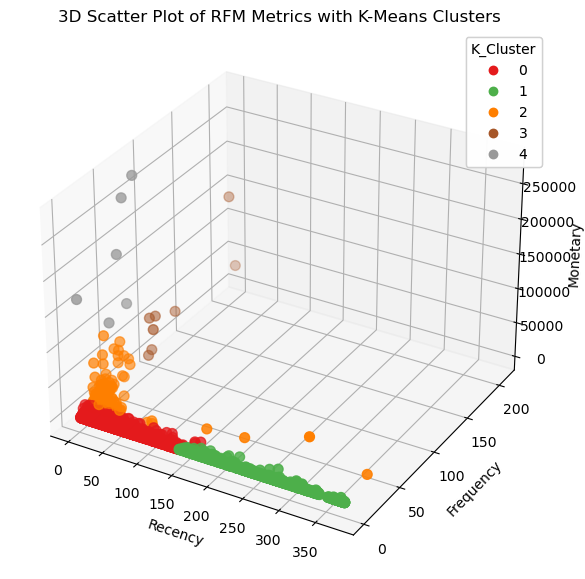

In [88]:
#3D scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], c=rfm['K_Cluster'], cmap='Set1', s=50)
ax.set_title('3D Scatter Plot of RFM Metrics with K-Means Clusters')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
legend1 = ax.legend(*scatter.legend_elements(), title="K_Cluster")
ax.add_artist(legend1)
plt.show()

### Business Inference:

**Cluster 0 - Customers with very low monetary value but a recent engagement (recency of 0-150 days):** These are likely new or infrequent buyers who have made a purchase recently but have not yet demonstrated significant spending. This segment represents an opportunity for growth as these customers are still actively engaging with the business. The marketing strategy should focus on nurturing these customers by providing personalized recommendations, welcome offers, and engaging content to encourage repeat purchases. By fostering a positive experience and building brand loyalty, businesses can gradually increase their spending and frequency, moving them into higher-value customer segments.

**Cluster 1- Customers with very low monetary value and a recency of 150 to over 365 days:** These are essentially inactive or lapsed customers who have not made a purchase in a long time and have historically spent very little. These customers are at high risk of being permanently lost if not re-engaged. To win them back, businesses should implement targeted win-back campaigns that include personalized emails with exclusive offers or significant discounts to spark their interest. Highlighting new products or services that might appeal to them, along with providing incentives such as loyalty points for renewed engagement, can help reactivate these customers and encourage them to make a purchase.

**Cluster 2 - Clusters with low monetary value and low frequency/recency:** This cluster indicates customers who rarely purchase and have not engaged recently, posing a risk of being lost. To re-engage these customers, businesses should implement targeted re-engagement campaigns featuring personalized emails with special offers, discounts, and incentives to encourage return visits. Additionally, conducting surveys to understand their needs and addressing potential barriers to purchasing can help rekindle interest. Highlighting new products or services and offering limited-time promotions can further incentivize these customers to increase their engagement and spending.

**Cluster 3 - Customers with intermediate monetary value (25,000 - 150,000) and a recency of 0 - 50 days:** These are actively engaged and have a moderate level of spending. These customers are valuable as they have recently interacted with the business and show potential for increased loyalty and spending. The marketing strategy for this segment should focus on nurturing their engagement through personalized experiences and tailored promotions. Offering loyalty rewards, exclusive access to new products, or personalized recommendations can further solidify their relationship with the business. Additionally, regular communication and follow-up on their recent purchases can enhance their customer experience, encouraging them to become high-value, repeat customers.

**Cluster 4 - Customers with high monetary value (>150,000) and recent engagement (recency of 0-50 days):** These are among the most valuable segments for any business. These customers have demonstrated significant spending and recent activity, indicating strong loyalty and satisfaction with the products or services. To maintain and enhance this relationship, businesses should focus on personalized experiences, exclusive rewards, and VIP treatment. Strategies may include early access to new products, personalized recommendations, loyalty programs with premium benefits, and proactive customer service. Ensuring these customers feel valued and appreciated will help sustain their high engagement and spending levels, further solidifying their loyalty.

### Conclusion

The customer segmentation analysis using RFM metrics and clustering techniques such as hierarchical clustering and K-means has provides valuable insights into the purchasing behaviors and engagement levels of customers. The distribution plots of Recency, Frequency, and Monetary values reveal critical patterns that can guide targeted marketing strategies. Clusters with low monetary value and low frequency/recency highlight the need for re-engagement campaigns to reactivate these customers. Conversely, clusters with high monetary value and recent engagement reflect the importance of attracting these valuable customers with personalized experiences and exclusive rewards to maintain their loyalty. Leveraging these insights would enable the business to implement data-driven strategies that enhance customer retention, increase spending, and optimize overall customer lifetime value.